# Source and Discover
This notebook demonstrates data sourcing and initial data discovery.  We will source raw stock pricing data using an API and then inspect the datasets to make sure they contain the information we expect.

In [25]:
%run config.ipynb

In [2]:
import pyEX  # For getting historical stock prices

In [17]:
# The stocks we want to fetch prices for
symbols = ['fb', 'xlf', 'aapl']

In [20]:
# Setup up local storage for our price data so we can cache historical data
store = pd.HDFStore('stock_prices.h5')

# Fetch IEX stock price data for our symbols and cache locally
for s in symbols:
    df = pyEX.chartDF(symbol=s, timeframe='5y')
    store.put(s, df, format="table", data_columns=True)

In [23]:
# Begin exploring stock price data
df = store.select(symbols[2]).set_index(df['date'])
df.head()

,change,changeOverTime,changePercent,close,date,high,label,low,open,unadjustedVolume,volume,vwap
date,,,,,,,,,,,,
2013-07-31,-0.103016,0.000000,-0.174,59.0108,2013-07-31,59.6384,"Jul 31, 13",58.6065,59.3316,11519690,80637830,59.0799
2013-08-01,0.540647,0.009161,0.916,59.5514,2013-08-01,59.5676,"Aug 1, 13",59.1060,59.4310,7351597,51461179,59.4117
2013-08-02,0.764674,0.022120,1.284,60.3161,2013-08-02,60.3565,"Aug 2, 13",59.5494,59.7254,9781011,68467077,59.9865
2013-08-05,0.901080,0.037390,1.494,61.2172,2013-08-05,61.3763,"Aug 5, 13",60.2653,60.5965,11369990,79589930,60.9707
2013-08-06,-0.147131,0.034897,-0.240,61.0701,2013-08-06,61.9417,"Aug 6, 13",60.6658,61.4337,11959349,83715443,61.2522


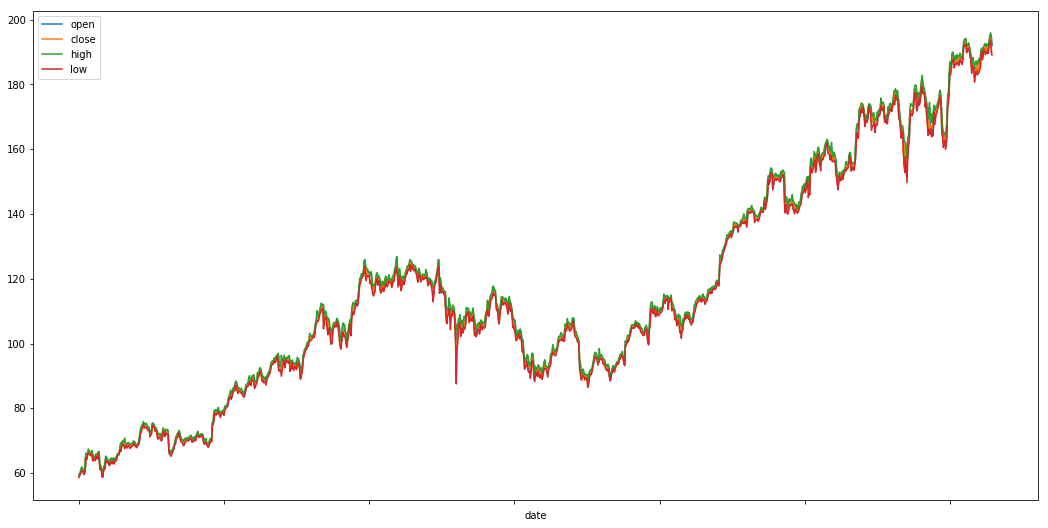

In [24]:
plt.rcParams['figure.figsize'] = [18,9]
df[['open', 'close', 'high', 'low']].plot()

In [27]:
# Connect to Cortex
cortex = Cortex.client()
builder = cortex.builder()

In [29]:
for s in symbols:
    df = store.select(s)
    ds = builder.dataset('demo/stock-prices-%s' % s).title('5Y Stock Prices - %s' % s).from_df(df, '/demo/deep-learning/stock-prices-5y-%s.json' % s, json=True).build()
    print('%s @ v%d' % (ds.title, ds.version))

5Y Stock Prices - fb @ v1
5Y Stock Prices - xlf @ v1
5Y Stock Prices - aapl @ v1


In [31]:
# Explore one Dataset to understand attribute properties
s = 'fb'
ds = cortex.dataset('demo/stock-prices-%s' % s)
c = ds.contract('stock-prices')
df = ds.as_pandas()

In [33]:
# View data dictionary
c.discover.data_dictionary(df)

,Attribute,Type,% Nulls,Count,Unique,Observations,Knowledge
0,change,float64,0.0,1259,647,max=14.66 | min=-41.24 | mean=0.11,
1,changeOverTime,float64,0.0,1259,1200,max=4.910326087 | min=-0.0065217391 | mean=2.02,
2,changePercent,float64,0.0,1259,1126,max=15.521 | min=-18.961 | mean=0.14,
3,close,float64,0.0,1259,1200,max=217.5 | min=36.56 | mean=111.24,
4,date,object,0.0,1259,1259,Sample: 2016-08-18 | 2015-06-15 | 2017-04-13,
5,high,float64,0.0,1259,1200,max=218.62 | min=37.07 | mean=112.29,
6,label,object,0.0,1259,1259,"Sample: Oct 11, 17 | May 17, 16 | Mar 17, 15",
7,low,float64,0.0,1259,1198,max=214.27 | min=36.0201 | mean=110.04,
8,open,float64,0.0,1259,1184,max=215.715 | min=36.36 | mean=111.2,
9,unadjustedVolume,int64,0.0,1259,1259,max=248809006 | min=5913066 | mean=33023851.93,


In [ ]:
# Export data dictionary to send to business SME
c.create_data_dictionary(df)